![](ESPInLogo.png)

# Vegetation effects on river migration and meandering

Channel migration is controlled by flow characteristics, sediment transport and <b>bank resistance</b>. Plants significantly and unquestionably affect river shape and migration by stabilizing the river banks and helping to produce cohesive floodplain clays, thereby increasing resistance to erosion.” [(Zinke, 2020)](https://www.nature.com/articles/s43017-019-0016-3). In this JupyterNotebook we will learn how the presence of vegetation can affect channel migration through different vegetation densities and distributions.


For this we will be using [meanderpy](https://github.com/zsylvester/meanderpy), a Python module that implements a simple numerical model of river meandering. This model is based on a nonlinear relationship based on field observations that suggested a complex link between curvature and migration rate. For more information, the model is further described in [Howard and Knutson, 1984](https://doi.org/10.1029/WR020i011p01659)

### Importing our libraries

For the creation of this notebook, functions from [meanderpy](https://github.com/zsylvester/meanderpy) have been edited as well as a brand new one. This is why, rather than importing meanderpy directly, we will be importing our version, called: <b>veg_meanderpy_ESPIn2023</b>.

In [1]:
# Importing libraries
import meanderpy as mp 
import matplotlib.pyplot as plt
import numpy as np

### Input parameters

In [2]:
nit = 2000              # number of iterations
W = 200.0               # channel width (m)
D = 6.0                 # channel depth (m)
depths = D * np.ones(nit,)   # channel depths for different iterations  
pad = 100                    # padding (number of nodepoints along centerline)
deltas = 50.0                # sampling distance along centerline 
kl = 60.0/(365*24*60*60.0)   # migration rate constant (m/s)
crdist = 2 * W               # threshold distance at which cutoffs occur
kv =  1.0e-12                # vertical slope-dependent erosion rate constant (m/s)
dt = 2*0.05*365*24*60*60.0   # time step (s)
dens = 1000                  # density of water (kg/m3)
saved_ts = 20                # which time steps will be saved
n_bends = 30                 # approximate number of bends you want to model
Sl = 0.0                     # initial slope (matters more for submarine channels than rivers)
t1 = 500                     # time step when incision starts
t2 = 700                     # time step when lateral migration starts
t3 = 1200                    # time step when aggradation starts
aggr_factor = 2e-9           # aggradation factor (m/s, about 0.18 m/year, it kicks in after t3)

As a way to incorporporate the vegetation, we will be changing [Chezy's coefficient](https://www.piping-designer.com/index.php/properties/fluid-mechanics/2492-chezy-coefficient), a simple metric that represents channel roughness. We know that channel migration and bank resistance do not directly relate to the roughness, however, when roughness is high, water velocity will be slower, decreasing bank erosion. Therefore, we will be <b>using this friction factor as a proxy to represent vegetation density </b> and estimate the channel migration rates. 

## Low Vegetation Density

We would expect a river to meander more with less vegetation, hence, a low friction factor. We will assign a relatively low value as an input to our model: 

In [3]:
Cf = 0.033 # high Chezy's (low veg density)
Cfs = Cf * np.ones((nit,)) # converting into an iterable array (will make it constant through each iteration)

### Initialize model

In [4]:
ch = mp.generate_initial_channel(W, depths[0], Sl, deltas, pad, n_bends)          # initialize channel
chb = mp.ChannelBelt(channels=[ch], cutoffs=[], cl_times=[0.0], cutoff_times=[])  # create channel belt object

### Run simulation

In [5]:
chb.migrate(1000,saved_ts,deltas,pad,crdist,depths,Cfs,kl,kv,dt,dens,t1,t2,t3,aggr_factor)

100%|██████████| 1000/1000 [00:26<00:00, 37.39it/s]


### Plot historic and the final river channel

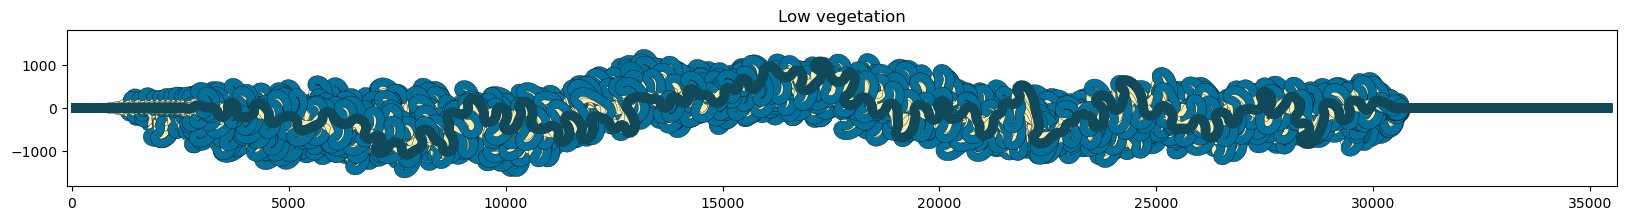

In [6]:
fig = chb.plot('strat', 20, 60, chb.cl_times[-1], len(chb.channels)) # plotting function
plt.title('Low vegetation')
plt.show(fig)

Notice how many cutoffs and meander bends! Let's now try with a higher roughness (more vegetation): 

## High Vegetation Density

In [7]:
Cf = 0.011 # low Chezy's (high veg)
Cfs = Cf * np.ones((nit,)) # converting into an iterable array (will make it constant through each iteration)

### Initialize model

In [8]:
ch = mp.generate_initial_channel(W, depths[0], Sl, deltas, pad, n_bends)          # initialize channel
chb = mp.ChannelBelt(channels=[ch], cutoffs=[], cl_times=[0.0], cutoff_times=[])  # create channel belt object

### Run simulation

In [ ]:
chb.migrate(nit,saved_ts,deltas,pad,crdist,depths,Cfs,kl,kv,dt,dens,t1,t2,t3,aggr_factor)

 74%|███████▎  | 1474/2000 [00:16<00:17, 29.74it/s] 

### Plot historic and the final river channel

In [ ]:
fig = chb.plot('strat', 20, 60, chb.cl_times[-1], len(chb.channels)) # plotting function
plt.title('High vegetation')
plt.show(fig)

Notice how there are not as many bends as the previous plots. 

# Temporal Evolution

In [ ]:
import imageio.v2 as imageio
import os

dirname2 = '/home/jupyter-nicoleuthalia@gmai-16d18/migrators/figuresforgif/' # directory where images are saved
prefix = 'movie' # prefix of the image files
output_file = 'output.gif' # name of the gif file to be created

# Get list of files in directory, sorted in ascending order
files = sorted([f for f in os.listdir(dirname2) if f.startswith(prefix) and f.endswith('.png')])

# Create a list to store the images
images = []
# Read each file and add it to the images list
for file in files:
    filepath = os.path.join(dirname2, file)
    images.append(imageio.imread(filepath))
    
# Write the images to a GIF file
imageio.mimsave(os.path.join(dirname2, output_file), images)

![](figuresforgif/output.gif)

# Bank division

Now let's see what happens when we change the vegetation density in the right and left bank. For this part of the notebook, functions from [meanderpy](https://github.com/zsylvester/meanderpy) have been edited. This is why, rather than importing meanderpy directly, we will be importing our version, called: <b>veg_meanderpy_ESPIn2023</b>.

We will be differenciating left and right bank with two coefficients, Cfs_south (right bank) and Cfs_north (left bank). 

In [ ]:
import veg_meanderpy_ESPIn2023 as vmp

### Defining spatially variable Cfs

In [ ]:
Cfs_south = 0.011 # High vegetation density
Cfs_north = 0.03 # Low vegetation density

In [ ]:
ch = vmp.generate_initial_channel(W, depths[0], Sl, deltas, pad, n_bends)          # initialize channel
chb = vmp.ChannelBelt(channels=[ch], cutoffs=[], cl_times=[0.0], cutoff_times=[])  # create channel belt object

In [ ]:
chb.migrate(nit,saved_ts,deltas,pad,crdist,depths,Cfs,kl,kv,dt,dens,t1,t2,t3,aggr_factor,Cfs_south,Cfs_north)

In [ ]:
fig = chb.plot('strat', 20, 60, chb.cl_times[-1], len(chb.channels)) # plotting function
plt.title('Mixed vegetation')
plt.show(fig)

Now let's quantify how many cutoffs are on each side of the river: 

### Number of cutoffs in north vs south bank

In [ ]:
# Calculate number of meanders north vs south
# old meanders / cutoffs
cutoff_nr = 0
north_cutoff = 0
south_cutoff = 0

for i in range(0, len(chb.cutoffs)): #iterating through cutoff objects
    pos_count = 0
    neg_count = 0
    other_count = 0
    for num in chb.cutoffs[i].y: #iterating through y coordinates in each cutoff object, counting pos / neg ones
        for y_coord in num:
            if y_coord > 0:
                pos_count += 1
            elif y_coord < 0:
                neg_count += 1
    if pos_count > neg_count:
        north_cutoff += 1
    elif pos_count < neg_count:
        south_cutoff += 1
    elif pos_count == neg_count:
        other_count += 1
print('Number of cutoffs in low vegetation (north): ', north_cutoff)
print('Number of cutoffs in high vegetation (south): ', south_cutoff)

We can see that the high vegetated area has less cutoffs than the one with lower vegetation!!

# Future Work

### Potentially adding a variable grid and incorporate into the model

In [ ]:
# Since we want vegetation patches: 

patch_size = 60
random_range = (0, 1) # I guess these should be the Cfs values?

# Generate random values
veg = np.random.uniform(*random_range, size=(len(ch.x), len(ch.y)))

# Create patches
patched_veg = np.zeros_like(veg)
for i in range(0, len(ch.y), patch_size):
    for j in range(0, len(ch.x), patch_size):
        value = np.random.uniform(*random_range)
        patched_veg[i:i+patch_size, j:j+patch_size] = value

# Create a heatmap
plt.imshow(patched_veg, cmap='Greens')
plt.colorbar()

# Show the plot
plt.show()